## Digit Recognizer
### Learn computer vision fundamentals with the famous MNIST data
- Defining the problem statement
- collecting the data
- preprocessing
- cnn
- ensembling predictions

## 1. Defining the problem statement
MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

## 2. Collecting the data
You can download the training set and test set directly from <a href = "https://www.kaggle.com/c/digit-recognizer">kaggle</a>

Let's import the necessary header files needed for this problem

In [1]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adadelta
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Let's load the dataset

In [0]:
test_df = pd.read_csv('test.csv.zip')
train_df = pd.read_csv('train.csv.zip')

In [28]:
test_df.shape

(28000, 784)

In [29]:
train_df.shape

(42000, 785)

In [30]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
print("The dimension of train data is",train_df.shape)

The dimension of train data is (42000, 785)


In [33]:
print("The dimension of test data is", test_df.shape)

The dimension of test data is (28000, 784)


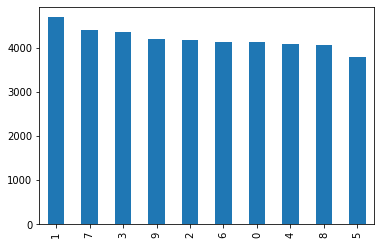

In [65]:
train_df['label'].value_counts().plot(kind = 'bar')

This plot clearly implies that the given dataset is a balanced dataset

Let's split the dataset into train set and test set

In [0]:
X_train = np.array(train_df.drop('label', axis = 1))
Y_train = np.array(train_df['label'])
X_test = np.array(test_df)

Let's visualize some of the numbers given in the test set

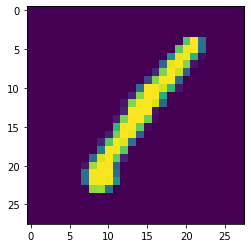

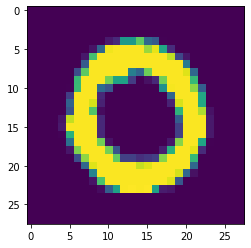

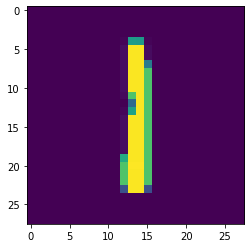

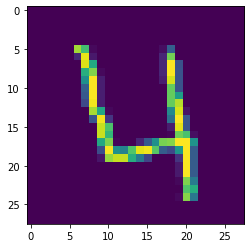

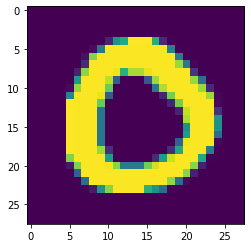

In [91]:
for i in range(5):
    plt.imshow(X_train[i][:,:,0])
    plt.show()

## 3. Preprocessing

### 3.1. Normalization
We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converge faster on [0..1] data than on [0..255].

In [67]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print('X_test shape:',X_test.shape)
print('Number of images in train set', X_train.shape[0])
print('Number of images in test set', X_test.shape[0])

X_train shape: (42000, 28, 28, 1)
X_test shape: (28000, 28, 28, 1)
Number of images in train set 42000
Number of images in test set 28000


### 3.2. One hot encoding

In [36]:
nclasses = Y_train.max() - Y_train.min() + 1
Y_train = to_categorical(Y_train, num_classes = nclasses)
print("Shape of ytrain after encoding: ", Y_train.shape) 

Shape of ytrain after encoding:  (42000, 10)


### 3.3. Splitting the dataset

In [37]:
seed = 1
np.random.seed(seed)
split_pct = 0.1
X_train, X_val, Y_train, Y_val = train_test_split(X_train,
                                              Y_train, 
                                              test_size=split_pct,
                                              random_state=seed,
                                              shuffle=True,
                                              stratify=Y_train
                                             )

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(37800, 28, 28, 1) (37800, 10) (4200, 28, 28, 1) (4200, 10)


### 3.4. Data Augmentation
Data augmentation is a strategy that enables us to significantly increase the diversity of data available for training models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks.Data Augmentation can be done easily using ImageDataGenerator in keras

In [0]:
datagen = ImageDataGenerator(
          featurewise_center=False,            
          samplewise_center=False,             
          featurewise_std_normalization=False, 
          samplewise_std_normalization=False,  
          zca_whitening=False,                 
          rotation_range=10,                   
          zoom_range = 0.1,                     
          width_shift_range=0.1,               
          height_shift_range=0.1,              
          horizontal_flip=False,               
          vertical_flip=False)                 

datagen.fit(X_train)

## 4. CNN

### 4.1 Defining the model

  I used lenet5 architecture with the following improvements:
  <img src='https://miro.medium.com/max/1580/1*6C0wlygR-GAnAwheozI1KQ.png'>
- Two stacked 3x3 filters replace the single 5x5 filters. These become nonlinear 5x5 convolutions
- A convolution with stride 2 replaces pooling layers. These become learnable pooling layers.
- ReLU activation replaces sigmoid.
- Batch normalization is added
- Dropout is added
- More feature maps (channels) are added
- An ensemble of 10 CNNs with bagging is used (single model gave me accuracy of .99341 after ensembling I got .99728

In [0]:
model = [0] * 10
for i in range(10):

    model[i] = Sequential()

    model[i].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4))

    model[i].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4))

    model[i].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Flatten())
    model[i].add(Dropout(0.4))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
   


### 4.2. Training the model
Note: Training this model will take a lot of time so i have attached the trained model in my repository 

In [40]:
s = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
model_log = [0] * 10
epochs = 45
for j in range(10):
    print("CNN ",j+1)
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    model_log[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2), callbacks=[s], verbose=1)
    print("CNN: ",j+1," ","Epochs: ",epochs," ","Train_accuracy: ",max(model_log[j].history['accuracy'])," ","Validation_accuracy: ",max(model_log[j].history['val_accuracy']))

CNN  1
Epoch 1/45
531/531 [==============================] - 23s 43ms/step - loss: 0.5528 - accuracy: 0.8277 - val_loss: 0.1204 - val_accuracy: 0.9606
Epoch 2/45
531/531 [==============================] - 21s 40ms/step - loss: 0.1518 - accuracy: 0.9538 - val_loss: 0.0506 - val_accuracy: 0.9839
Epoch 3/45
531/531 [==============================] - 21s 40ms/step - loss: 0.1084 - accuracy: 0.9670 - val_loss: 0.0272 - val_accuracy: 0.9923
Epoch 4/45
531/531 [==============================] - 21s 40ms/step - loss: 0.0920 - accuracy: 0.9719 - val_loss: 0.0538 - val_accuracy: 0.9847
Epoch 5/45
531/531 [==============================] - 21s 39ms/step - loss: 0.0802 - accuracy: 0.9756 - val_loss: 0.0238 - val_accuracy: 0.9939
Epoch 6/45
531/531 [==============================] - 21s 40ms/step - loss: 0.0735 - accuracy: 0.9773 - val_loss: 0.0338 - val_accuracy: 0.9881
Epoch 7/45
531/531 [==============================] - 21s 40ms/step - loss: 0.0653 - accuracy: 0.9807 - val_loss: 0.0179 - val_ac

### 4.3 Visualizing train and validation set results

Let's visualize the train set and validation set accuracy

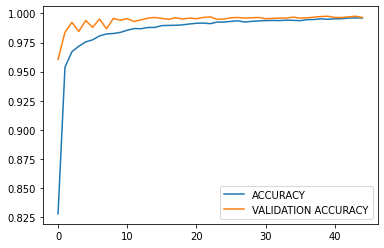

In [49]:
plt.plot(model_log[0].history['accuracy'],label = 'ACCURACY')
plt.plot(model_log[0].history['val_accuracy'],label = 'VALIDATION ACCURACY')
plt.legend()

From the above plot it is clear that accuracy approaches towards 1. In this case (1st model) validation accuracy seems to be slightly greater than training accuracy

Let's visualize the loss in train set and validation set

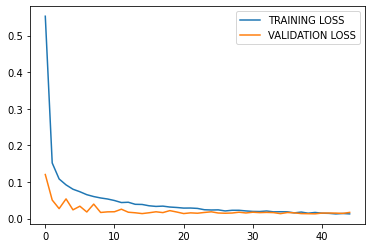

In [50]:
plt.plot(model_log[0].history['loss'],label = 'TRAINING LOSS')
plt.plot(model_log[0].history['val_loss'],label = 'VALIDATION LOSS')
plt.legend()

## 5. Ensembling predictions

In [0]:
results = np.zeros( (X_test.shape[0],10) ) 
for j in range(10):
    results = results + model[j].predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("/Ensemble_predictions.csv",index=False)


## 6. Conclusion

 In this article, we explored a dataset hosted by <a href="http://kaggle.com">Kaggle</a>.

- Defining the problem statement
- loading the data
- preprocessing
- cnn
- ensembling predictions

I trained a simple lenet 5 and got an accuracy of .98814. After that I followed this <a href = " https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist">Kernel</a> and  made modifications in lenet 5 architecutre and got an accuracy of .99200. Ensembling and data augmentation made my accuracy jump to .99728.

This entire notebook has been compiled on <a href = "https://colab.research.google.com/notebooks/intro.ipynb#recent=true">google collab</a>

 In my repository I am attaching my trained model as training takes a lot of time(it took me 3hrs in google collab). If you are struggling importing that model then please follow my another notebook on this repository.

## 7. References

- https://www.youtube.com/watch?v=KdhphuuHyxA
- https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist